In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import shutil, os

In [67]:
h_pixels = np.load('h_pixels_screen.npy')
v_pixels = np.load('v_pixels_screen.npy')

In [2]:
def arr_creat(upperleft, upperright, lowerleft, lowerright):
    arr = np.linspace(np.linspace(lowerleft, lowerright, arrwidth), 
                      np.linspace(upperleft, upperright, arrwidth), arrheight, dtype=int)
    return arr[:, :, None]

arrwidth = 1920
arrheight = 1080

r = arr_creat(0,   255, 0,   255)
g = arr_creat(0,   0,   255, 0)
b = arr_creat(255, 255, 0,   0)

img = np.concatenate([r, g, b], axis=2)

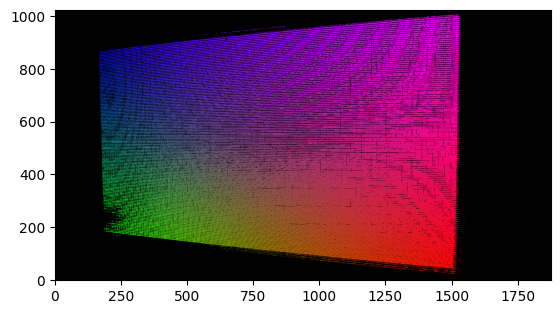

In [69]:
result_img = np.zeros((h_pixels.shape[0], h_pixels.shape[1], 3), dtype=int)

for i in range(h_pixels.shape[1]):
    for j in range(h_pixels.shape[0]):
        h_value = h_pixels[j, i]
        v_value = v_pixels[j, i]
        if h_value == -1 or v_value == -1:
            result_img[j, i] = [0, 0, 0]
        else:
            h_value = min(1919, h_value)
            v_value = min(1079, v_value)
            #print(h_value, v_value)
            result_img[j, i] = img[v_value, h_value]

plt.imshow(result_img, origin="lower")

# Show the plot
plt.show()


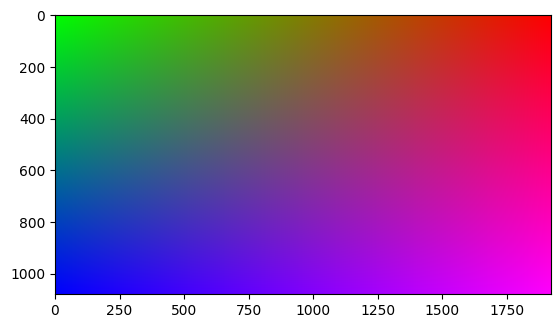

In [4]:
plt.imshow(img)

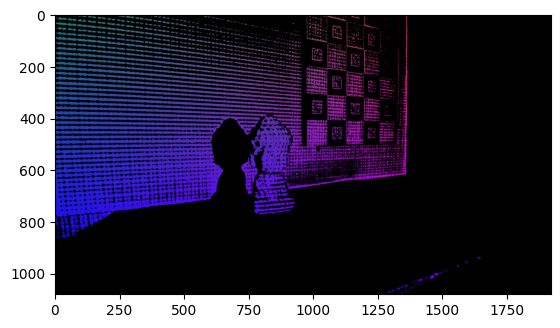

In [15]:
arrwidth = 1280
arrheight = 720

r = arr_creat(0,   255, 0,   255)
g = arr_creat(0,   0,   255, 0)
b = arr_creat(255, 255, 0,   0)

img = np.concatenate([r, g, b], axis=2)
base_path = '../data/recordings/record_9/'

h_pixels = np.load(base_path+'h_pixels.npy')
v_pixels = np.load(base_path+'v_pixels.npy')

result_img = np.zeros((h_pixels.shape[0], h_pixels.shape[1], 3), dtype=int)

for i in range(h_pixels.shape[1]):
    for j in range(h_pixels.shape[0]):
        h_value = h_pixels[j, i]
        v_value = v_pixels[j, i]
        if h_value == -1 or v_value == -1:
            result_img[j, i] = [0, 0, 0]
        else:
            h_value = min(arrwidth-1, h_value)
            v_value = min(arrheight-1, v_value)
            #print(h_value, v_value)
            result_img[j, i] = img[v_value, h_value]

plt.imshow(result_img)
plt.show()

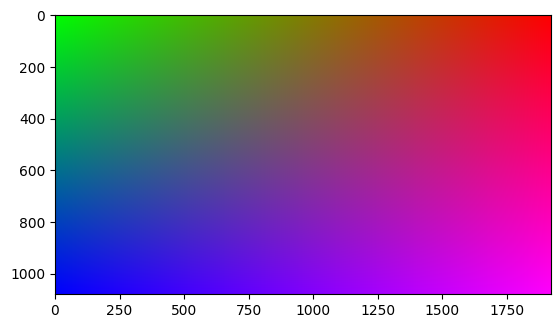

In [8]:
plt.imshow(img)
plt.show()